In [12]:
from scipy.constants import epsilon_0
epsilon_0

%matplotlib notebook
import matplotlib.pyplot as plt
# print(plt.style.available)  # show available template
plt.style.use(['seaborn-ticks','seaborn-paper'])  # use a templet

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'
params = {
    'figure.figsize': [8, 6], # Note! figure unit is inch!  scale fontz size 2.54 to looks like unit cm
    'axes.labelsize': 7*2.54, # scale 2.54 to change to figure unit looks as cm
    'font.size':  7*2.54,
    'lines.linewidth':2,
    'legend.fontsize': 7*2.54,
    'xtick.labelsize': 6*2.54,
    'ytick.labelsize': 6*2.54,
    'text.usetex': False,  
    'xtick.direction': "in",
    'ytick.direction': "in", # ticket inside
    'legend.frameon' : True, 
    'legend.edgecolor': 'black',
    'legend.shadow': True,
    'legend.framealpha':1,
#     'patch.linewidth' : 0.5, 
}
mpl.rcParams.update(params)
# mpl.rcParams.items()
# other package import
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar

import numpy as np
from qutip import *
import itertools

In [13]:
def GenOmega(laserPolarization, s):
    # laserPolarization:  (pi, sigma_plus, sigma_minus) compoment
    # s saturation parameter
    
    linewidth = 19.7 * 1e6  # Hz
    pi, sigma_plus, sigma_minus = laserPolarization
    _omega = 2 * np.pi *linewidth * np.sqrt(s)

    omega = np.zeros((8, 8))
    omega[0][7] = omega[7][0] = \
    omega[1][4] = omega[4][1] = \
    omega[1][6] = omega[6][1] = \
    omega[2][7] = omega[7][2] = _omega * sigma_plus

    omega[0][5] = omega[5][0] = \
    omega[2][5] = omega[5][2] = \
    omega[3][4] = omega[4][3] = \
    omega[3][6] = omega[6][3] = _omega * sigma_minus

    omega[0][6] = omega[6][0] = \
    omega[1][5] = omega[5][1] = \
    omega[2][4] = omega[4][2] = \
    omega[3][7] = omega[7][3] = _omega * pi
    
    return omega


def Hamiltonian(tau, s, Delta, delta, B):
    # tau; time of chirp
    # s ：saturation parameter
    # detuning： \Delta   GHz
    # delta：    \delta   GHz
    
    # spontanouse decay rate
    linewidth = 19.7 * 1e6  # Hz
    
    # hyperfine splitting
    s_splitting = 12642.812118466  # MHz
    p_splitting = 2105  # MHz
    quadratic_shift = 310.8  # B**2 Hz (B in Gauss)
    
    mF = np.zeros(8)
    mF[1] = -1
    mF[3] = 1
    mF[5] = -1
    mF[7] = 1
    
    cg = np.zeros((8, 8))
    # pi transitions
    cg[0][6] = cg[6][0] = 1 / np.sqrt(3)
    cg[1][5] = cg[5][1] = -1 / np.sqrt(3)
    cg[2][4] = cg[4][2] = 1 / np.sqrt(3)
    cg[3][7] = cg[7][3] = 1 / np.sqrt(3)

    # sigma+ transitions
    cg[0][7] = cg[7][0] = -1 / np.sqrt(3)
    cg[1][4] = cg[4][1] = 1 / np.sqrt(3)
    cg[1][6] = cg[6][1] = 1 / np.sqrt(3)
    cg[2][7] = cg[7][2] = 1 / np.sqrt(3)

    # sigma- transitions
    cg[0][5] = cg[5][0] = -1 / np.sqrt(3)
    cg[2][5] = cg[5][2] = -1 / np.sqrt(3)
    cg[3][4] = cg[4][3] = 1 / np.sqrt(3)
    cg[3][6] = cg[6][3] = -1 / np.sqrt(3)
    
    alpha = (Delta-12.642)/(Delta+12.642)
#     alpha_p = np.sqrt(np.sqrt(((alpha**2 -1)**2 /2)**2 + alpha**2) + (alpha**2 -1)**2 /2)
#     alpha_s = np.sqrt(np.sqrt(((alpha**2 -1)**2 /2)**2 + alpha**2) - (alpha**2 -1)**2 /2)
#     sat_x= s*alpha_p
#     sat_y= s*alpha_s/alpha
    
    sat_x= s
    sat_y= s/alpha    
    
    def delta_coeff(t, args):  #双光子失谐
        return 2*np.pi*delta*1e9*np.cos(np.pi*t/tau)

    def sat_coeff(t, args):   #波形
        return np.sin(np.pi*t/tau)
    
    # X line porlar light : sigma_+ + sigma_-
    Polarization_x = (0, 1/np.sqrt(2), 1/np.sqrt(2))
    omega = GenOmega(Polarization_x, sat_x)
    
    off_diagonal_elements = 0
    for i, j in itertools.product(range(8),range(8)):
        off_diagonal_elements += omega[i][j] / 2 * cg[i][j]**2 * basis(8,i) * basis(8,j).dag()
        
    # Y line porlar light : sigma_+ - sigma_-
    Polarization_y = (0, 1/np.sqrt(2), -1/np.sqrt(2))
    omega = GenOmega(Polarization_y, sat_y)
    for i, j in itertools.product(range(8),range(8)):
        off_diagonal_elements += omega[i][j] / 2 * cg[i][j] ** 2 * basis(8,i) * basis(8,j).dag()

    
    ee = np.sum(basis(8,i) * basis(8,i).dag() for i in (4, 5, 6, 7))
    g1 = np.sum(basis(8,i) * basis(8,i).dag() for i in (1,2,3))
    g0 = basis(8,0) * basis(8,0).dag()
    
    ee_shifts = 2 * np.pi*0.47e6*B*(mF[5]* basis(8,5) * basis(8,5).dag()+\
                                      mF[7]* basis(8,7) * basis(8,7).dag())- 2*np.pi*p_splitting*1e6*basis(8,4) * basis(8,4).dag()
    g1_shifts = 2 * np.pi*1.4e6*B*(mF[1]* basis(8,1) * basis(8,1).dag()+\
                                      mF[3]* basis(8,3) * basis(8,3).dag())
    g0_shifts = 2 * np.pi * quadratic_shift * B ** 2* basis(8,0) * basis(8,0).dag()

    
    diagonal_elements= 2*np.pi*Delta*1e9*(ee-g1) + 2*np.pi*Delta*1e9*(ee-g0) + (ee_shifts-g1_shifts) + (ee_shifts-g0_shifts)
    diagonal_elements/=2.0
    

    c_ops = []
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][4]* basis(8,i) * basis(8,4).dag())
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][5]* basis(8,i) * basis(8,5).dag())
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][6]* basis(8,i) * basis(8,6).dag())
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][7]* basis(8,i) * basis(8,7).dag())
        
    
    H = [diagonal_elements,[(-ee+g0)/2.0,delta_coeff],[off_diagonal_elements,sat_coeff]]
    
    return (H, c_ops)

<IPython.core.display.Javascript object>


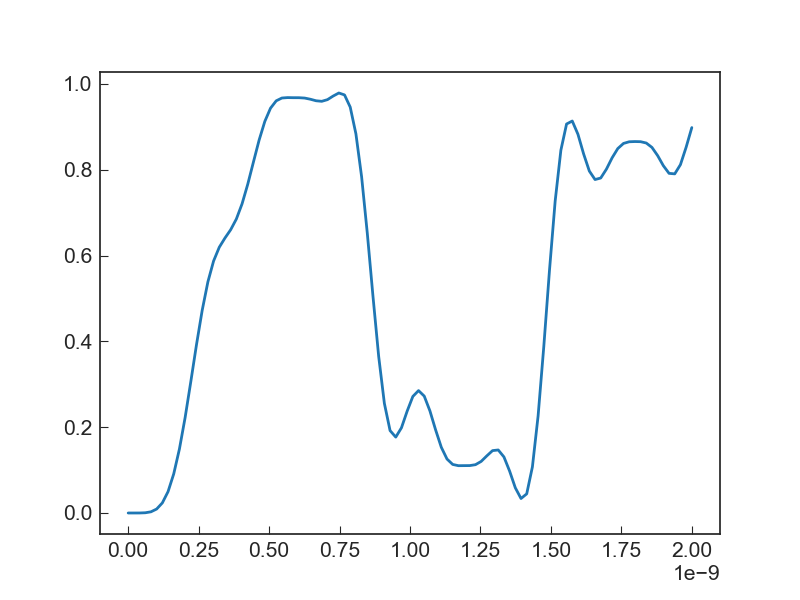

In [22]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.6e-9,10e6,90,8.75,10)
t = np.linspace(0, 2e-9, 100)
output = mesolve(H, psi0, t, c_ops, population)

plt.plot(t,output.expect[0])

In [5]:
np.log10(1-max(output.expect[0]))

-2.9641723570748923

In [6]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 1e-9, 20)

array = np.zeros((50,50))
ss = np.linspace(1,15,50) 
DELTA = np.linspace(3,9,50)
for i,s in enumerate(ss):
    for j,delta in enumerate(DELTA):
        H, c_ops = Hamiltonian(1e-9, s*1e6,120, delta, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


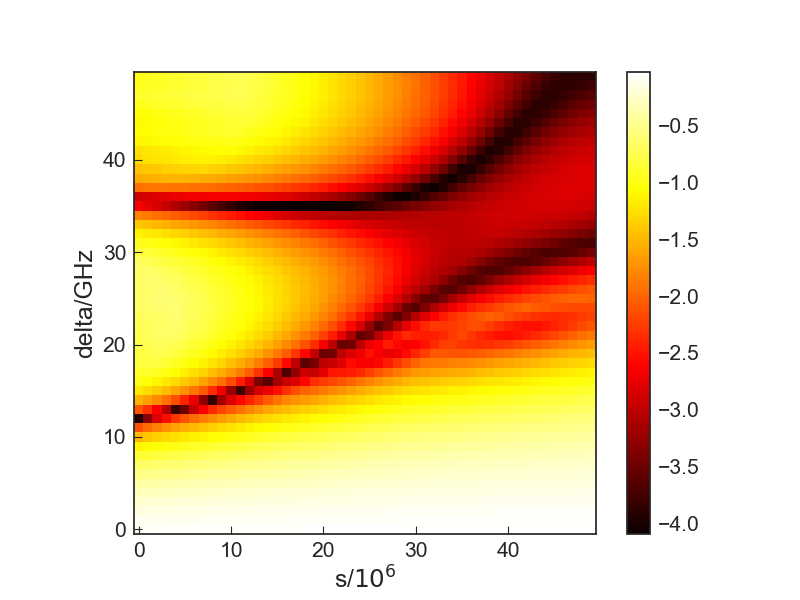

In [45]:
plt.figure()
plt.xlabel('s/$10^{6}$')
plt.ylabel('delta/GHz')
plt.imshow(array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


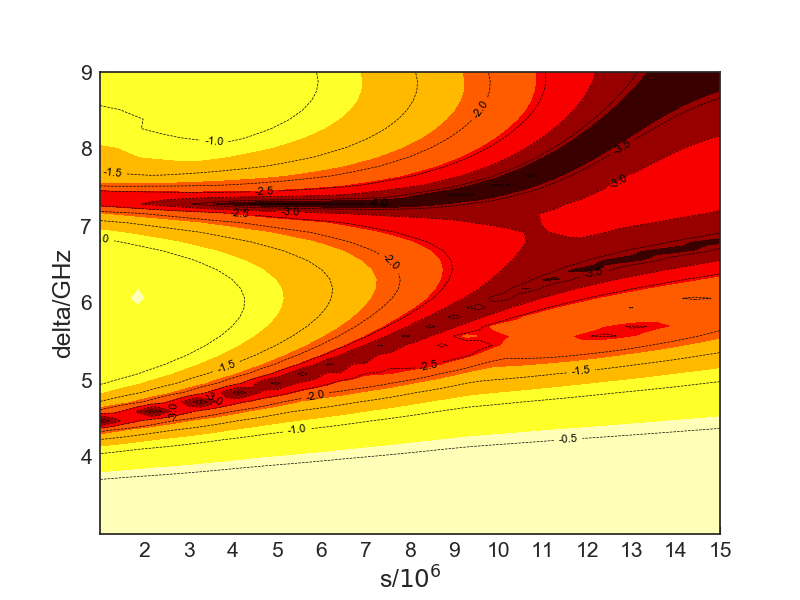

<a list of 20 text.Text objects>

In [88]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1,15,50) 
y = np.linspace(3,9,50)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.xlabel('s/$10^{6}$')
plt.ylabel('delta/GHz')
my_x_ticks = np.arange(2, 16, 1)
my_y_ticks = np.arange(4, 10, 1)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Z,origin='lower', cmap=plt.get_cmap('hot'))

cntr = plt.contour(X, Y, Z, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)





In [99]:
import pandas as pd
import numpy as np
df = pd.DataFrame(array,index = np.around(ss,decimals=2),columns = np.around(DELTA,decimals=2))
df.to_csv('Infidelity_with_detune_intensity.csv',index_label='index')

In [107]:
import pandas as pd
import numpy as np
df = pd.DataFrame(array,index = np.around(ss,decimals=2),columns = np.around(taoo,decimals=2))
df.to_csv('Infidelity_with_tao_intensity.csv',index_label='index')

In [6]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 1e-9, 20)

array = np.zeros((30,30))
ss = np.linspace(1,15,30) 
taoo = np.linspace(0.5,1,30)
for i,s in enumerate(ss):
    for j,tao in enumerate(taoo):
        H, c_ops = Hamiltonian(tao*1e-9, s*1e6,120, 8, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


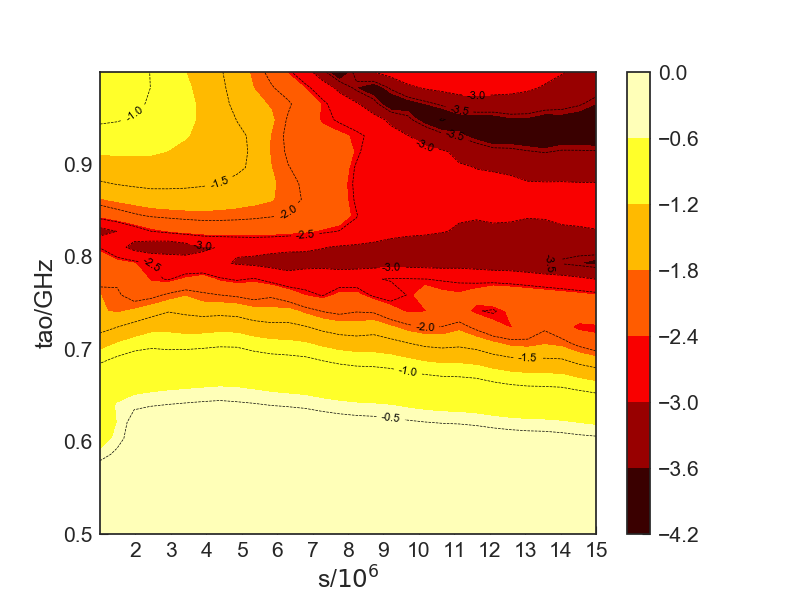

<a list of 16 text.Text objects>

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1,15,30) 
y = np.linspace(0.5,1,30)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.xlabel('s/$10^{6}$')
plt.ylabel('tao/GHz')
my_x_ticks = np.arange(2, 16, 1)
my_y_ticks = np.arange(0.5, 1, 0.1)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

In [26]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 0.5e-9, 20)

Array = np.zeros((30,30))
ss = np.linspace(10,100,30) 
ddelta = np.linspace(6,15,30)
for i,s in enumerate(ss):
    for j,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.3e-9, s*1e6, 120, delta, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


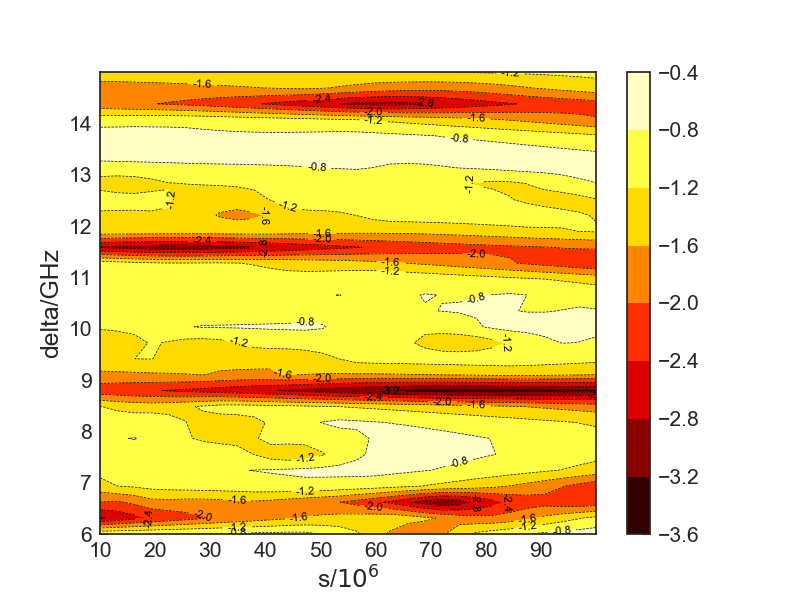

<a list of 46 text.Text objects>

In [61]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(10,100,30) 
y = np.linspace(6,15,30)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.xlabel('s/$10^{6}$')
plt.ylabel('delta/GHz')
my_x_ticks = np.arange(10, 100, 10)
my_y_ticks = np.arange(6, 15, 1)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

In [159]:
Array = np.zeros((20,20))
ddetuning = np.linspace(2,10,20) 
ddelta = np.linspace(100,150,20)
for i,detuning in enumerate(ddetuning):
    for j,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.2e-9, 20*1e6, delta, detuning, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


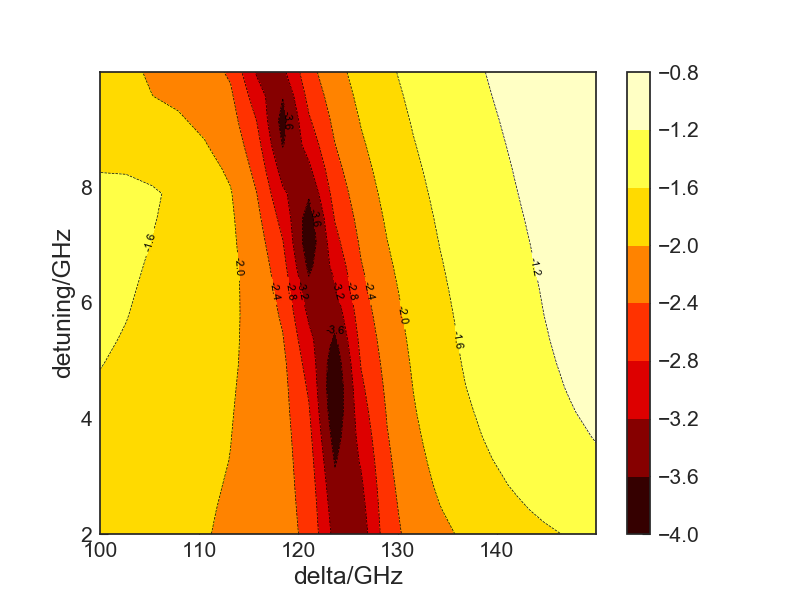

<a list of 14 text.Text objects>

In [160]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(100,150,20) 
y = np.linspace(2,10,20)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.ylabel('detuning/GHz')
plt.xlabel('delta/GHz')
my_x_ticks = np.arange(100,150,10)
my_y_ticks = np.arange(2,10,2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

In [137]:
Array = np.zeros((20,20))
ddetuning = np.linspace(7,7.1,20) 
ddelta = np.linspace(117,125,20)
for i,detuning in enumerate(ddetuning):
    for j,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.2e-9, 20*1e6, delta, detuning, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


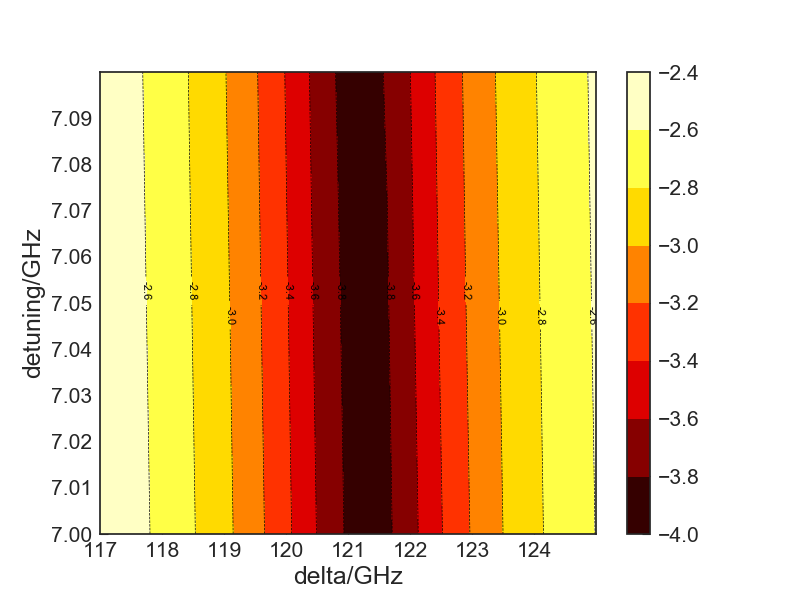

<a list of 14 text.Text objects>

In [143]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(117,125,20) 
y = np.linspace(7,7.1,20)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.ylabel('detuning/GHz')
plt.xlabel('delta/GHz')
my_x_ticks = np.arange(117, 125, 1)
my_y_ticks = np.arange(7, 7.1, 0.01)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

<IPython.core.display.Javascript object>


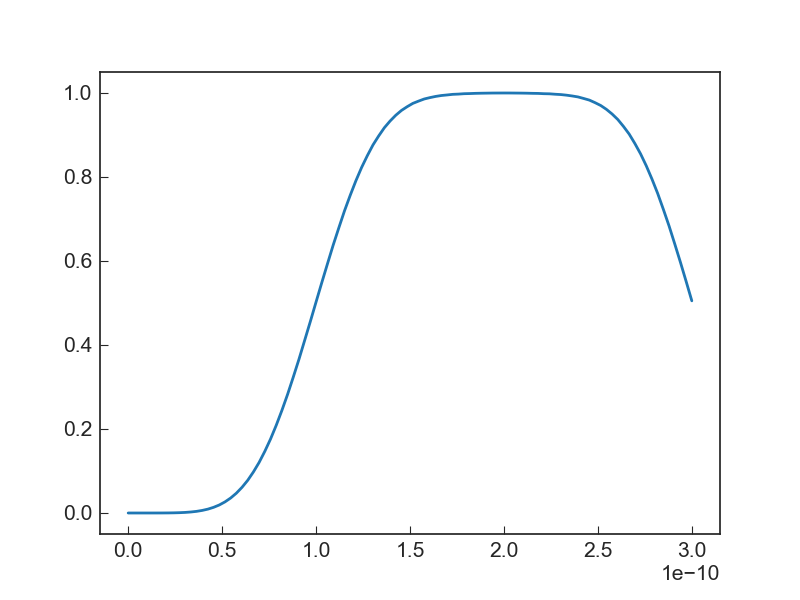

0.99986112461168675

In [147]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10)
t = np.linspace(0, 0.3e-9, 100)
output = mesolve(H, psi0, t, c_ops, population)
plt.figure()
plt.plot(t,output.expect[0])
max(output.expect[0])

In [172]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 0.3e-9, 20)

Array = np.zeros((20,20))
ddetuning = np.linspace(2,10,20) 
ddelta = np.linspace(20,160,20)
for i,detuning in enumerate(ddetuning):
    for j,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.2e-9, 10*1e6, delta, detuning, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


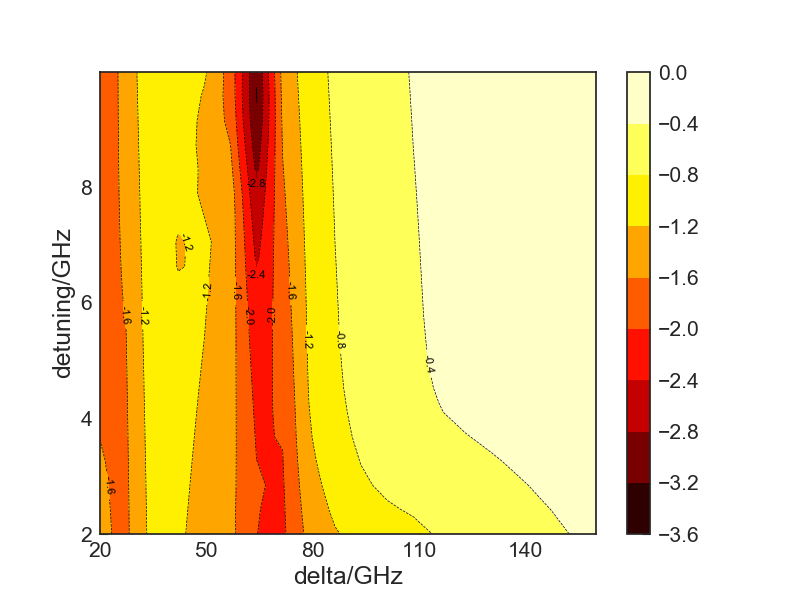

<a list of 14 text.Text objects>

In [174]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(20,160,20) 
y = np.linspace(2,10,20)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.ylabel('detuning/GHz')
plt.xlabel('delta/GHz')
my_x_ticks = np.arange(20,160,30)
my_y_ticks = np.arange(2,10,2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

In [110]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 0.3e-9, 20)

Array = np.zeros((20,20))
ddetuning = np.linspace(2,2.5,20) 
ddelta = np.linspace(20,90,20)
for i,detuning in enumerate(ddetuning):
    for j,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.2e-9, 10*1e6, delta, detuning, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


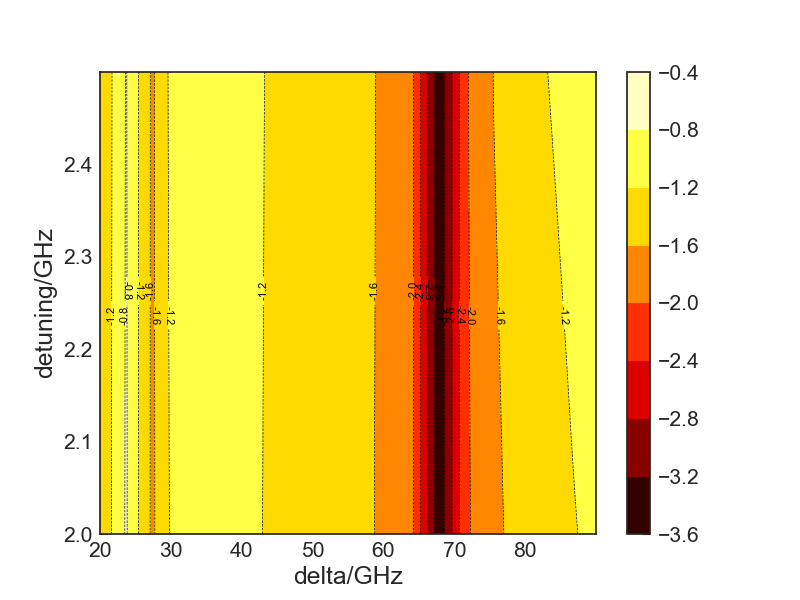

<a list of 19 text.Text objects>

In [127]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(20,90,20) 
y = np.linspace(2,2.5,20)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.xlabel('delta/GHz')
plt.ylabel('detuning/GHz')
my_x_ticks = np.arange(20, 90, 10)
my_y_ticks = np.arange(2, 2.5, 0.1)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

<IPython.core.display.Javascript object>


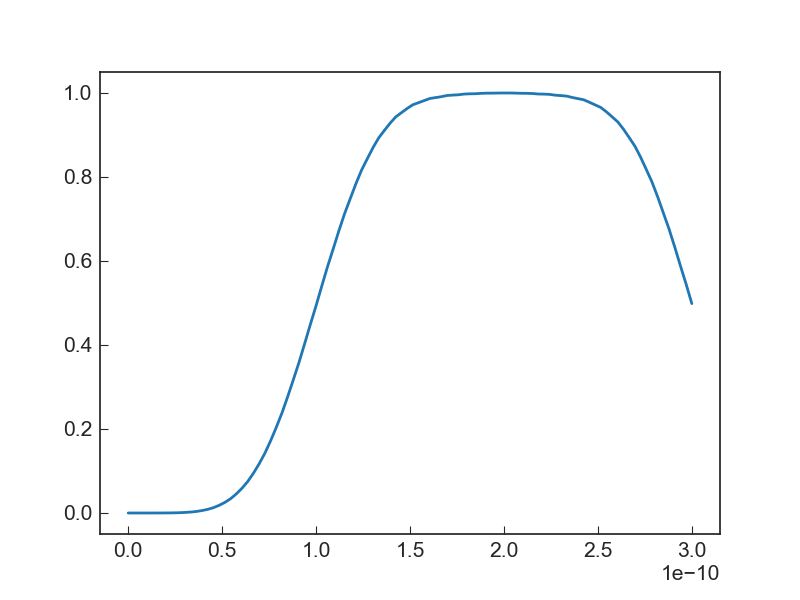

0.99979889483563511

In [166]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,10e6,68,2.3,10)
t = np.linspace(0, 0.3e-9, 100)
output = mesolve(H, psi0, t, c_ops, population)
plt.figure()
plt.plot(t,output.expect[0])
max(output.expect[0])

In [148]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 0.3e-9, 20)

Array = np.zeros((20,20))
ddetuning = np.linspace(0.5,2,20) 
ddelta = np.linspace(20,60,20)
for j,detuning in enumerate(ddetuning):
    for i,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.2e-9, 5*1e6, delta, detuning, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


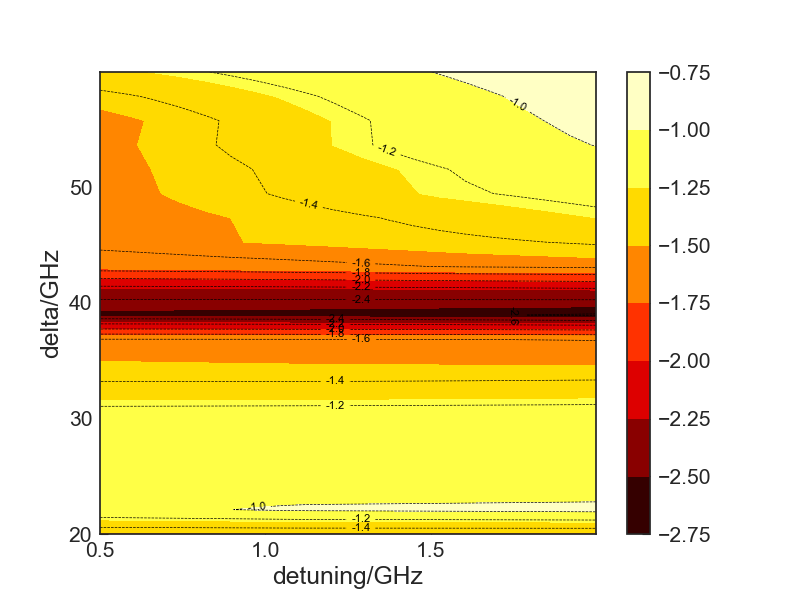

<a list of 19 text.Text objects>

In [153]:
import numpy as np
import matplotlib.pyplot as plt

y = np.linspace(20,60,20) 
x = np.linspace(0.5,2,20)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.ylabel('delta/GHz')
plt.xlabel('detuning/GHz')
my_y_ticks = np.arange(20, 60, 10)
my_x_ticks = np.arange(0.5, 2, 0.5)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

<IPython.core.display.Javascript object>


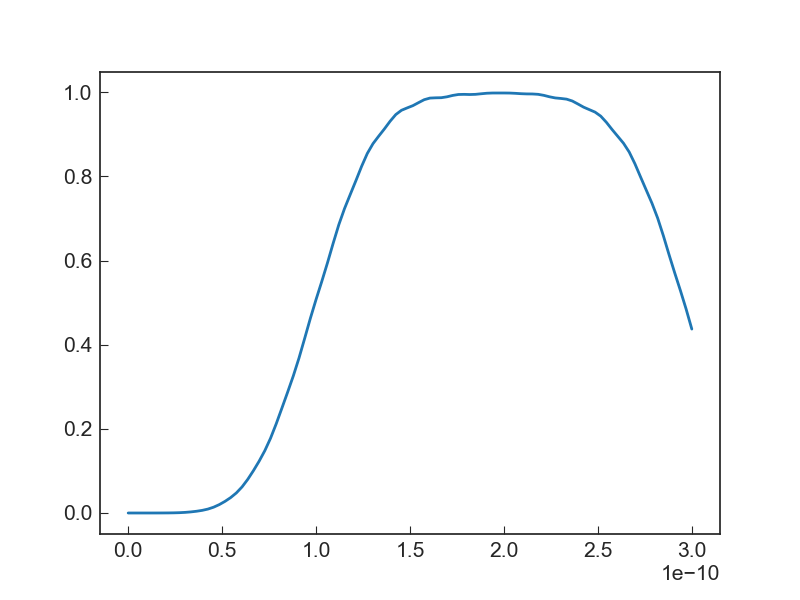

0.99807323395353831

In [155]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,5e6,39,1.25,10)
t = np.linspace(0, 0.3e-9, 100)
output = mesolve(H, psi0, t, c_ops, population)
plt.figure()
plt.plot(t,output.expect[0])
max(output.expect[0])

In [163]:
np.exp(2)

7.3890560989306504